Generate all possible MNIST digits

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

import sys
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.datasets import mnist
from random import randint
# Any results you write to the current directory are saved as output.

### Generator Model Class

In [8]:
class Generator(object):
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100):
        self.W = width
        self.H = height
        self.C = channels
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)

        self.LATENT_SPACE_SIZE = latent_size
        self.latent_space = np.random.normal(0,1,(self.LATENT_SPACE_SIZE,))

        self.Generator = self.model()
        self.Generator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        self.save_model()
        self.summary()

    def model(self, block_starting_size=128,num_blocks=4):
        model = Sequential()
        
        block_size = block_starting_size 
        model.add(Dense(block_size, input_shape=(self.LATENT_SPACE_SIZE,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        for i in range(num_blocks-1):
            block_size = block_size * 2
            model.add(Dense(block_size))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.W * self.H * self.C, activation='tanh'))
        model.add(Reshape((self.W, self.H, self.C)))
        
        return model

    def summary(self):
        return self.Generator.summary()

    def save_model(self):
        plot_model(self.Generator.model, to_file='Generator_Model.png')

### Descriminator Model Class

In [9]:
class Discriminator(object):
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100):
        self.CAPACITY = width*height*channels
        self.SHAPE = (width,height,channels)
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)


        self.Discriminator = self.model()
        self.Discriminator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'] )
        self.save_model()
        self.summary()

    def model(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense(self.CAPACITY, input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(int(self.CAPACITY/2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        return model

    def summary(self):
        return self.Discriminator.summary()

    def save_model(self):
        plot_model(self.Discriminator.model, to_file='Discriminator_Model.png')



### Generative Adversarial model Class

In [10]:
class GAN(object):
    def __init__(self,discriminator,generator):
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
        
        self.Generator = generator

        self.Discriminator = discriminator
        self.Discriminator.trainable = False
        
        self.gan_model = self.model()
        self.gan_model.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        self.save_model()
        self.summary()

    def model(self):
        model = Sequential()
        model.add(self.Generator)
        model.add(self.Discriminator)
        return model

    def summary(self):
        return self.gan_model.summary()

    def save_model(self):
        plot_model(self.gan_model.model, to_file='GAN_Model.png')


### Trainer Class

In [11]:
class Trainer:
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100, epochs =50000, batch=32, checkpoint=50,model_type=-1):
        self.W = width
        self.H = height
        self.C = channels
        self.EPOCHS = epochs
        self.BATCH = batch
        self.CHECKPOINT = checkpoint
        self.model_type=model_type

        self.LATENT_SPACE_SIZE = latent_size

        self.generator = Generator(height=self.H, width=self.W, channels=self.C, latent_size=self.LATENT_SPACE_SIZE)
        self.discriminator = Discriminator(height=self.H, width=self.W, channels=self.C)
        self.gan = GAN(generator=self.generator.Generator, discriminator=self.discriminator.Discriminator)

        self.load_MNIST()

    def load_MNIST(self,model_type=3):
        allowed_types = [-1,0,1,2,3,4,5,6,7,8,9]
        if self.model_type not in allowed_types:
            print('ERROR: Only Integer Values from -1 to 9 are allowed')

        (self.X_train, self.Y_train), (_, _) = mnist.load_data()
        if self.model_type!=-1:
            self.X_train = self.X_train[np.where(self.Y_train==int(self.model_type))[0]]
        
        # Rescale -1 to 1
        # Find Normalize Function from CV Class  
        self.X_train = ( np.float32(self.X_train) - 127.5) / 127.5
        self.X_train = np.expand_dims(self.X_train, axis=3)
        return

    def train(self):
        for e in range(self.EPOCHS):
            # Train Discriminator
            # Make the training batch for this model be half real, half noise
            # Grab Real Images for this training batch
            count_real_images = int(self.BATCH/2)
            starting_index = randint(0, (len(self.X_train)-count_real_images))
            real_images_raw = self.X_train[ starting_index : (starting_index + count_real_images) ]
            x_real_images = real_images_raw.reshape( count_real_images, self.W, self.H, self.C )
            y_real_labels = np.ones([count_real_images,1])

            # Grab Generated Images for this training batch
            latent_space_samples = self.sample_latent_space(count_real_images)
            x_generated_images = self.generator.Generator.predict(latent_space_samples)
            y_generated_labels = np.zeros([self.BATCH-count_real_images,1])

            # Combine to train on the discriminator
            x_batch = np.concatenate( [x_real_images, x_generated_images] )
            y_batch = np.concatenate( [y_real_labels, y_generated_labels] )

            # Now, train the discriminator with this batch
            discriminator_loss = self.discriminator.Discriminator.train_on_batch(x_batch,y_batch)[0]
        
            # Generate Noise
            x_latent_space_samples = self.sample_latent_space(self.BATCH)
            y_generated_labels = np.ones([self.BATCH,1])
            generator_loss = self.gan.gan_model.train_on_batch(x_latent_space_samples,y_generated_labels)

#             print ('Epoch: '+str(int(e))+', [Discriminator :: Loss: '+str(discriminator_loss)+'], [ Generator :: Loss: '+str(generator_loss)+']')
                        
            if e % self.CHECKPOINT == 0 :
                print('Epoch: {} Discriminator Loss: {:0.6f}, Generator Loss {:0.6f}'.format(e, discriminator_loss, generator_loss))                
                self.plot_checkpoint(e)
        return

    def sample_latent_space(self, instances):
        return np.random.normal(0, 1, (instances,self.LATENT_SPACE_SIZE))

    def plot_checkpoint(self,e):
        filename = "/data/sample_"+str(e)+".png"

        noise = self.sample_latent_space(16)
        images = self.generator.Generator.predict(noise)
        
        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.H,self.W])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
      
        plt.show()
        plt.tight_layout()
#         plt.savefig(filename)
        plt.close('all')
        return

### Train the Model

/opt/conda/lib/python3.6/site-packages/keras/engine/sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
__________

/opt/conda/lib/python3.6/site-packages/keras/engine/sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 392)               307720    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 392)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 393       
Total params: 923,553
Trainable params: 923,553
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.6/site-packages/keras/engine/sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         1514128   
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 923553    
Total params: 2,437,681
Trainable params: 1,510,288
Non-trainable params: 927,393
_________________________________________________________________


/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 Discriminator Loss: 0.844158, Generator Loss 0.691583


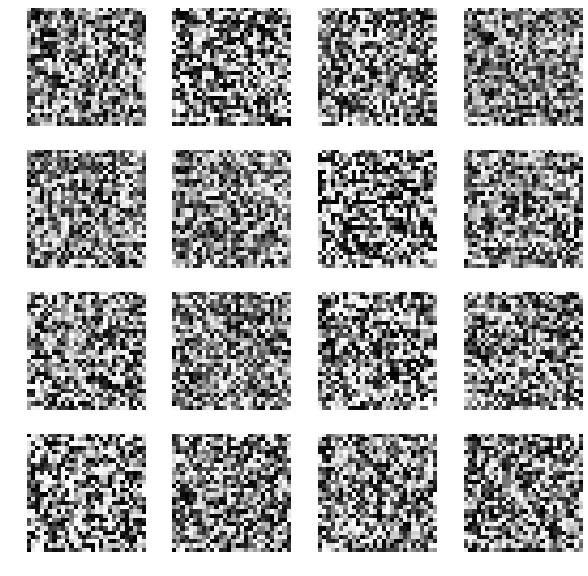

Epoch: 1000 Discriminator Loss: 0.037922, Generator Loss 7.312132


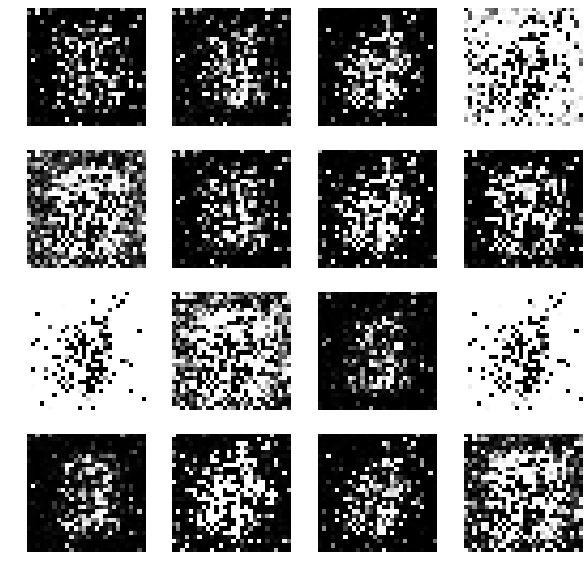

Epoch: 2000 Discriminator Loss: 0.156515, Generator Loss 6.703179


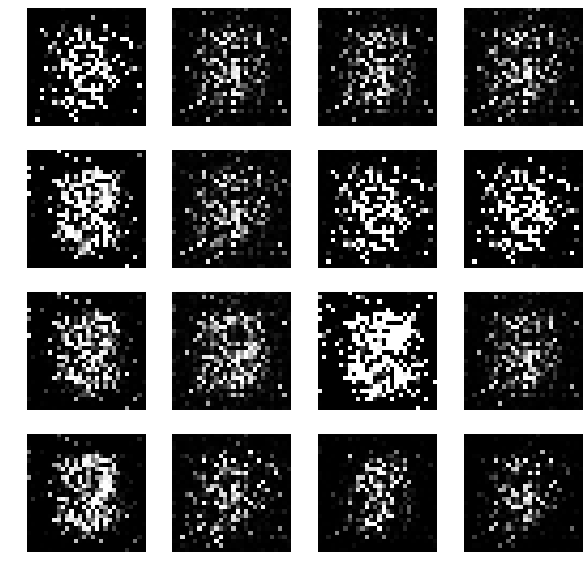

Epoch: 3000 Discriminator Loss: 0.071869, Generator Loss 4.746185


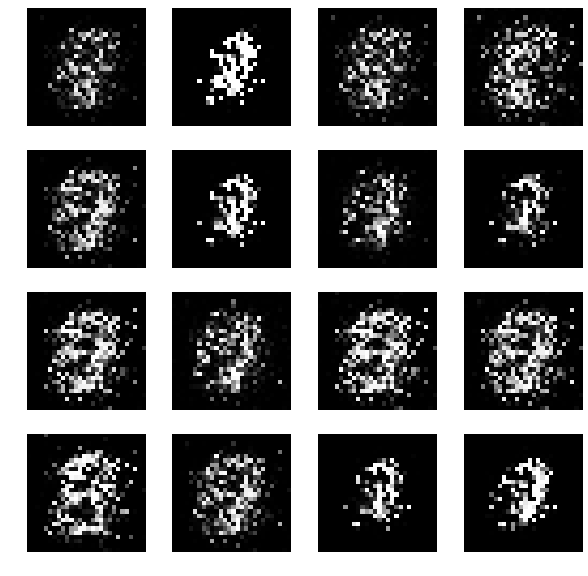

Epoch: 4000 Discriminator Loss: 0.390164, Generator Loss 5.427290


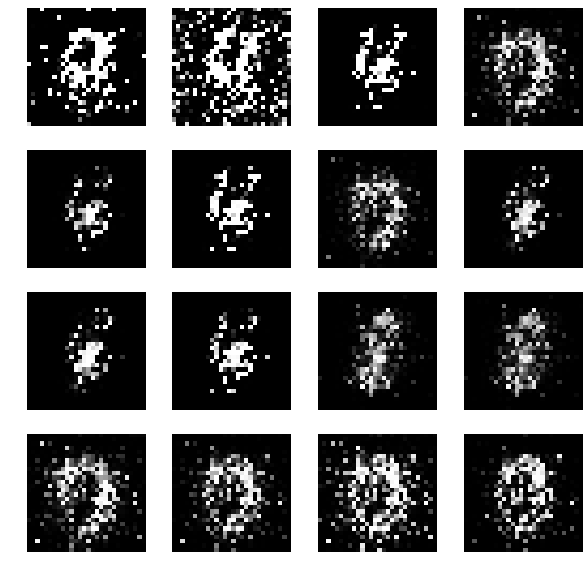

Epoch: 5000 Discriminator Loss: 0.332779, Generator Loss 3.973802


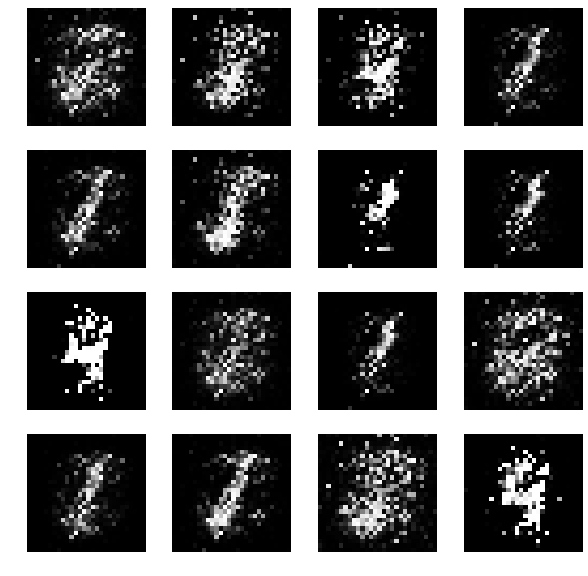

Epoch: 6000 Discriminator Loss: 0.194164, Generator Loss 4.026756


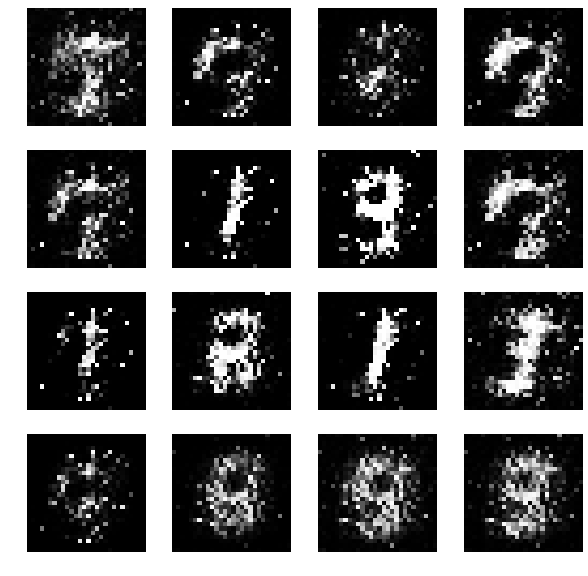

Epoch: 7000 Discriminator Loss: 0.228932, Generator Loss 3.857519


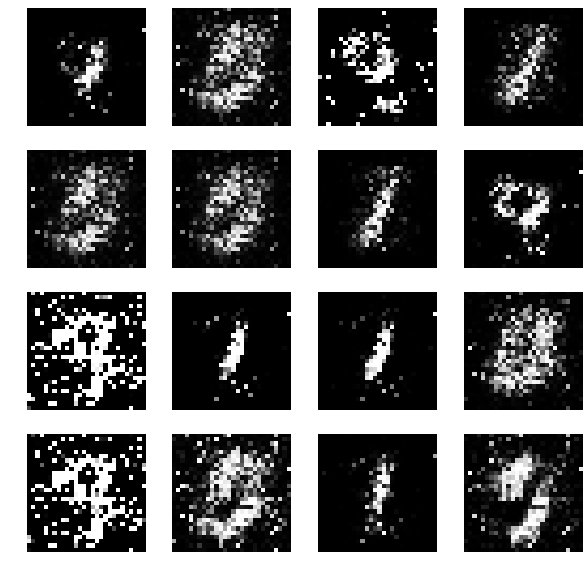

Epoch: 8000 Discriminator Loss: 0.363109, Generator Loss 1.698358


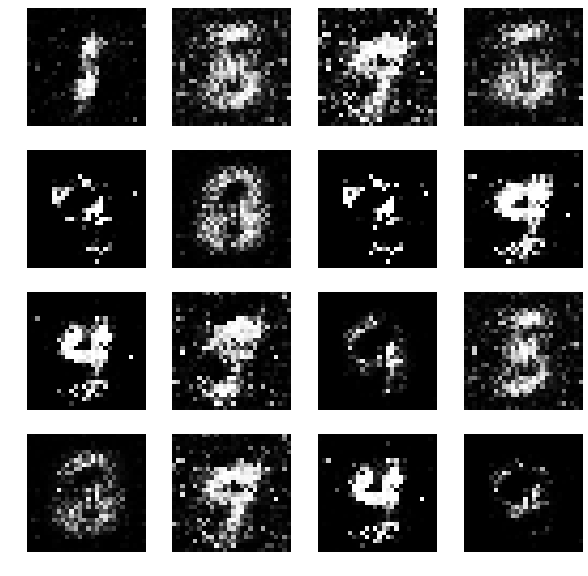

Epoch: 9000 Discriminator Loss: 0.633595, Generator Loss 1.796506


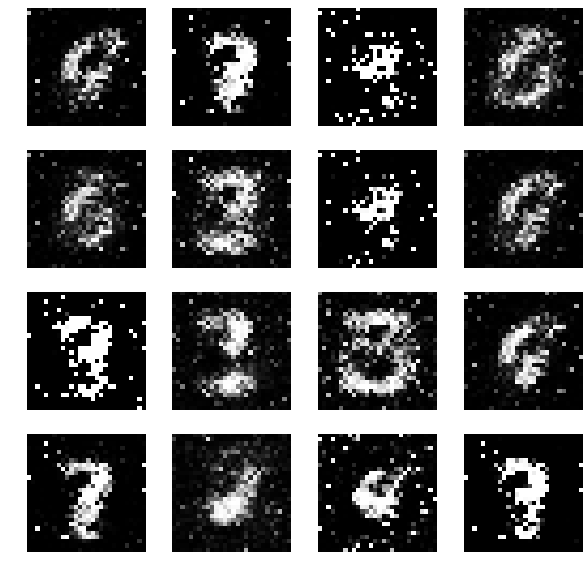

Epoch: 10000 Discriminator Loss: 0.378118, Generator Loss 1.983785


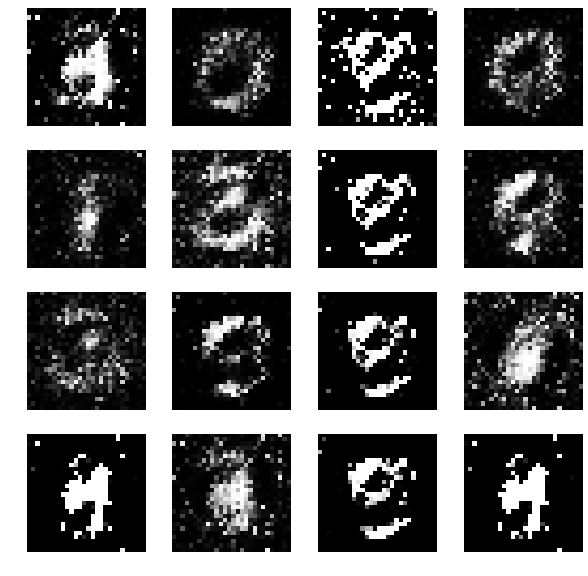

Epoch: 11000 Discriminator Loss: 0.336957, Generator Loss 3.295064


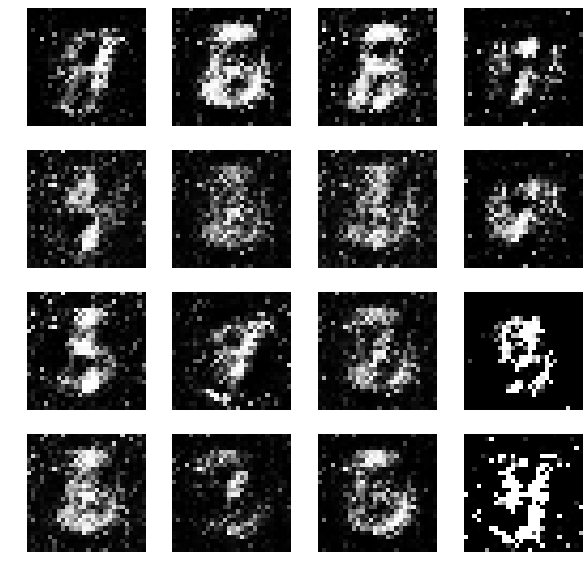

Epoch: 12000 Discriminator Loss: 0.564756, Generator Loss 1.606069


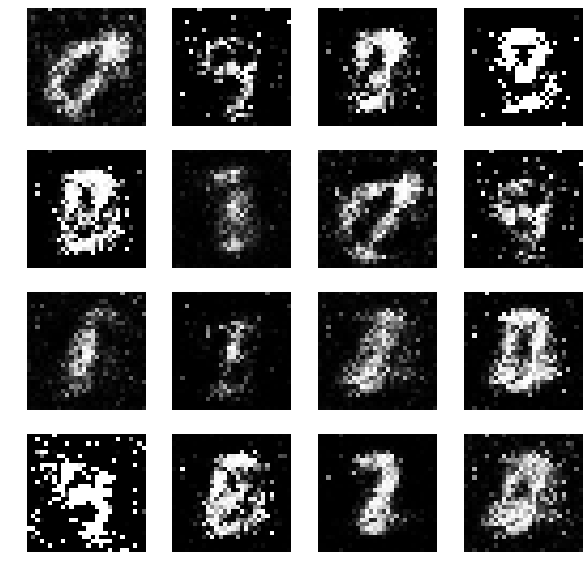

Epoch: 13000 Discriminator Loss: 0.418150, Generator Loss 1.367779


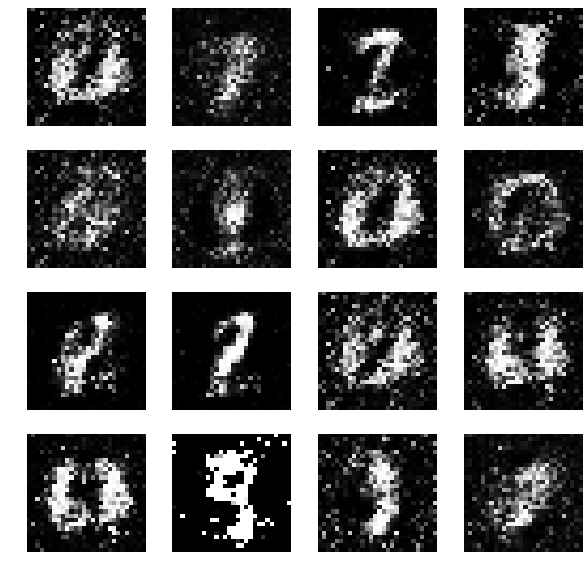

Epoch: 14000 Discriminator Loss: 0.384150, Generator Loss 2.902007


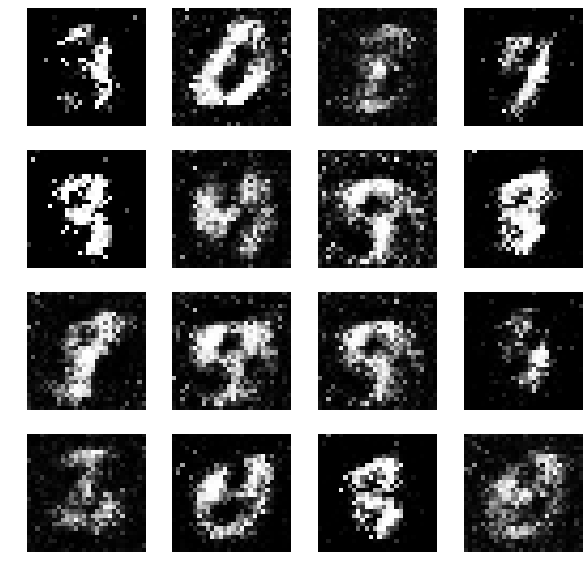

Epoch: 15000 Discriminator Loss: 0.508716, Generator Loss 2.298599


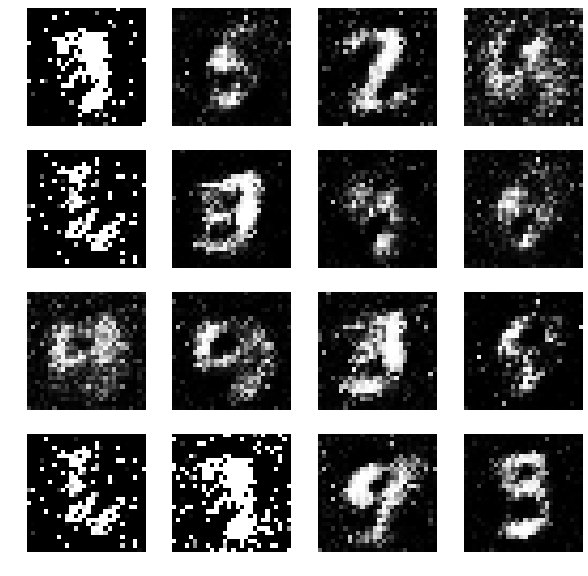

Epoch: 16000 Discriminator Loss: 0.432360, Generator Loss 2.237173


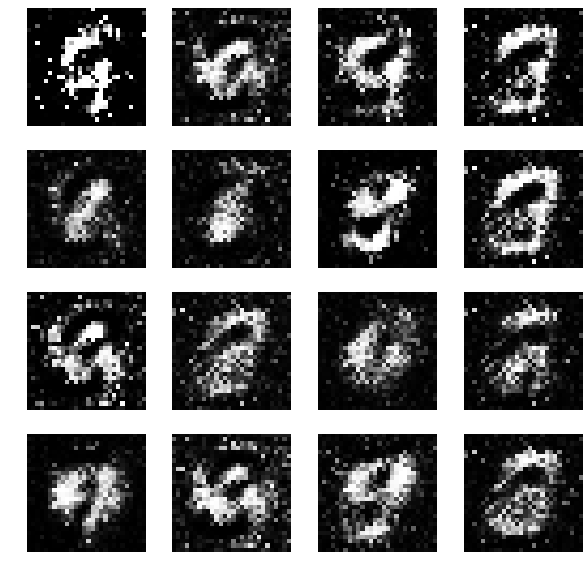

Epoch: 17000 Discriminator Loss: 0.607542, Generator Loss 2.415165


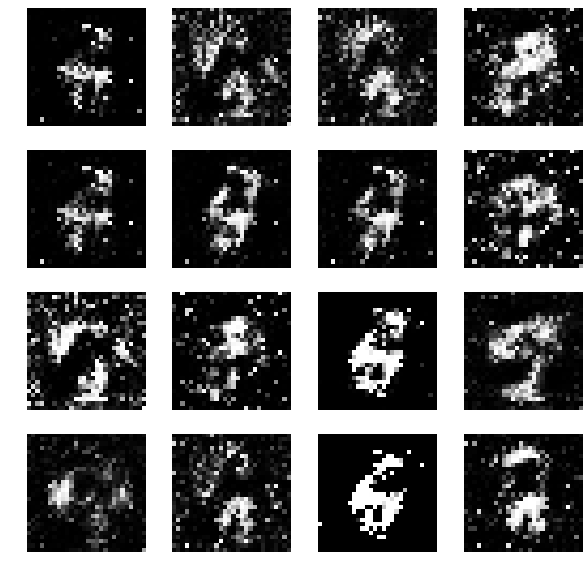

Epoch: 18000 Discriminator Loss: 0.460487, Generator Loss 1.725574


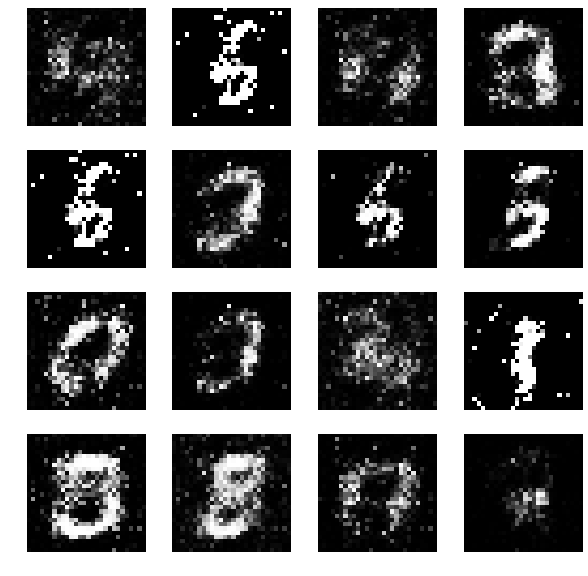

Epoch: 19000 Discriminator Loss: 0.383403, Generator Loss 1.547242


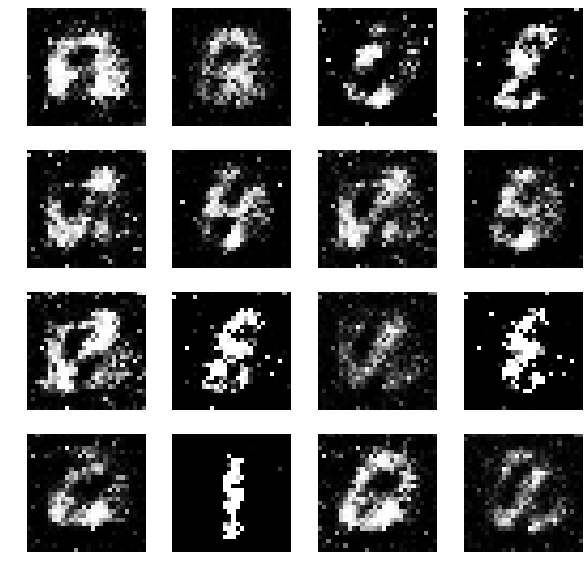

Epoch: 20000 Discriminator Loss: 0.554129, Generator Loss 1.799156


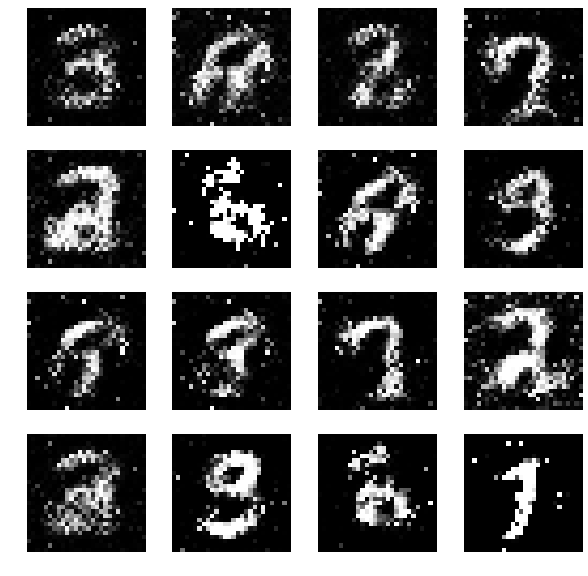

Epoch: 21000 Discriminator Loss: 0.741213, Generator Loss 1.956943


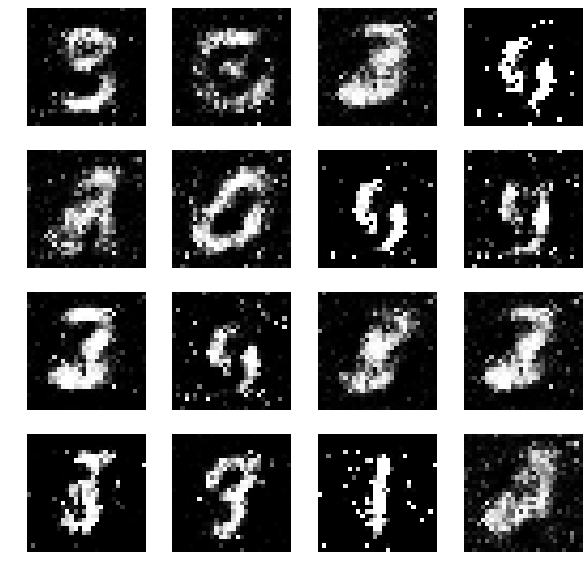

Epoch: 22000 Discriminator Loss: 0.446853, Generator Loss 1.500176


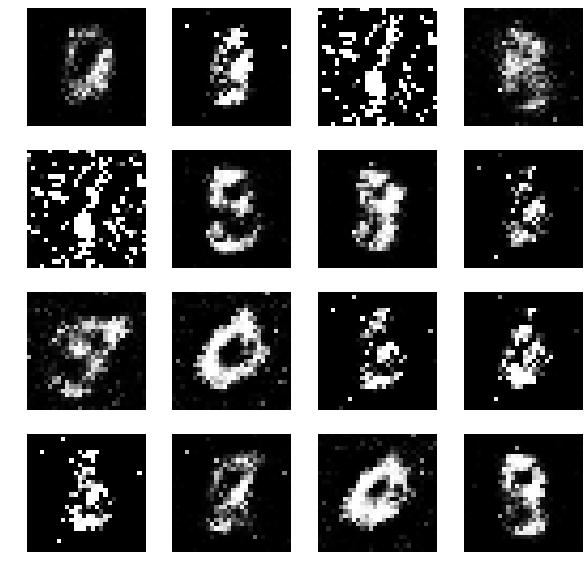

Epoch: 23000 Discriminator Loss: 0.550232, Generator Loss 1.689032


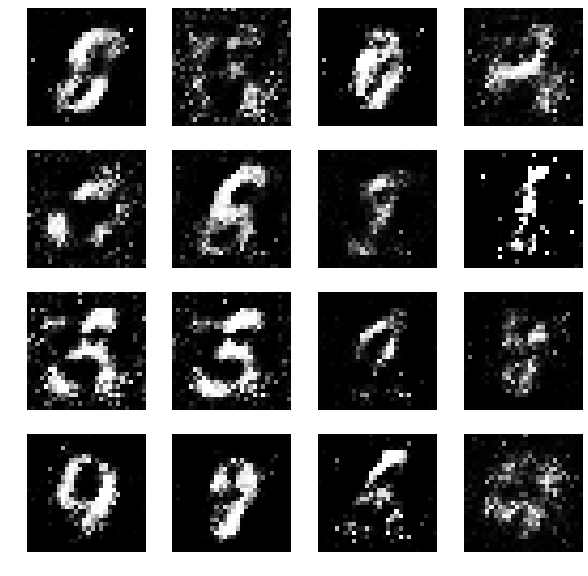

Epoch: 24000 Discriminator Loss: 0.713450, Generator Loss 0.952120


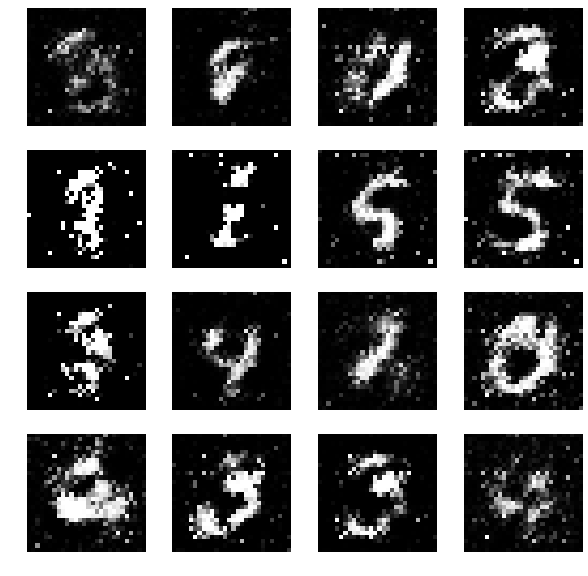

Epoch: 25000 Discriminator Loss: 0.609366, Generator Loss 1.374816


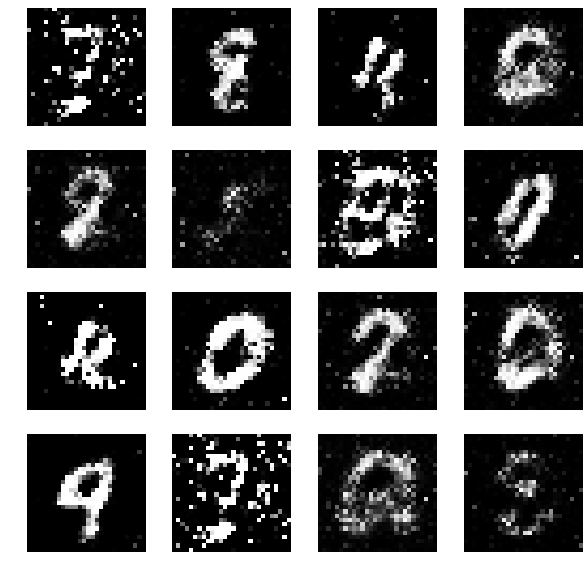

Epoch: 26000 Discriminator Loss: 0.466927, Generator Loss 0.984474


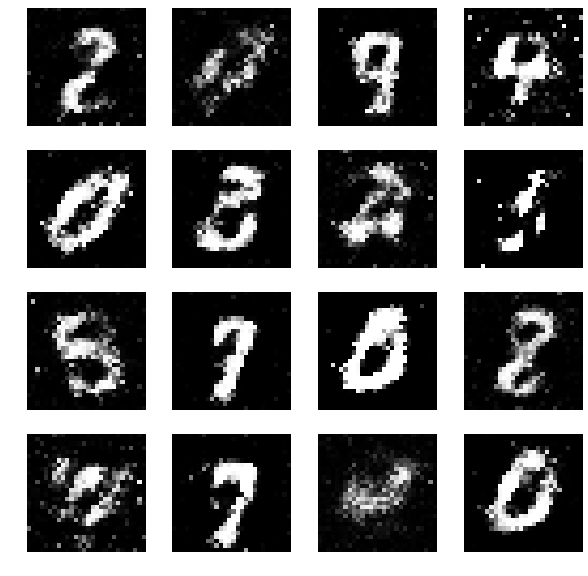

Epoch: 27000 Discriminator Loss: 0.554324, Generator Loss 0.762231


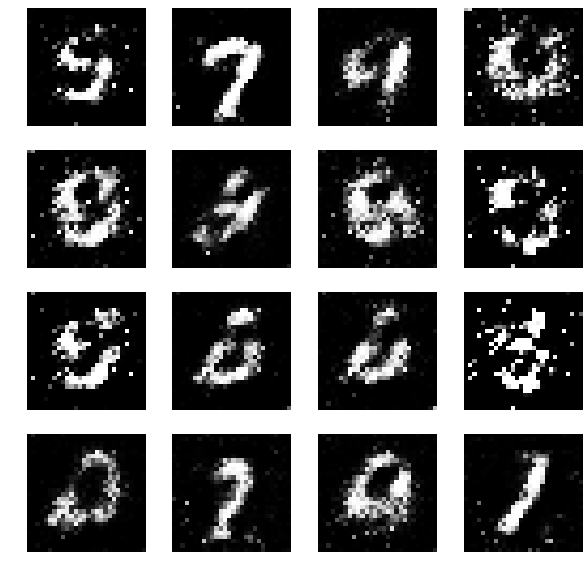

Epoch: 28000 Discriminator Loss: 0.336725, Generator Loss 2.033866


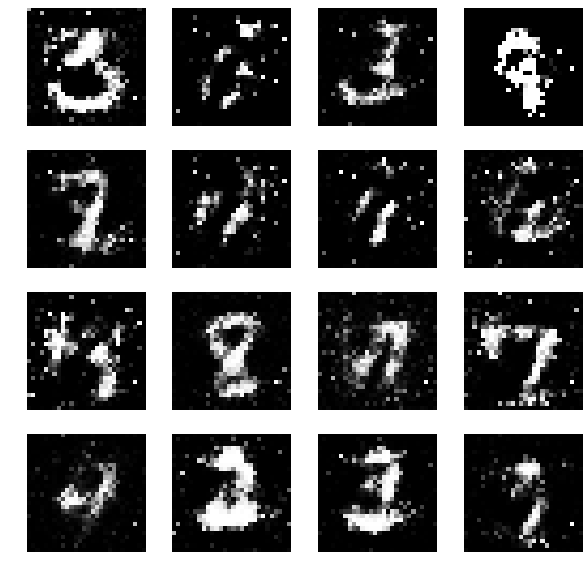

Epoch: 29000 Discriminator Loss: 0.498744, Generator Loss 1.648168


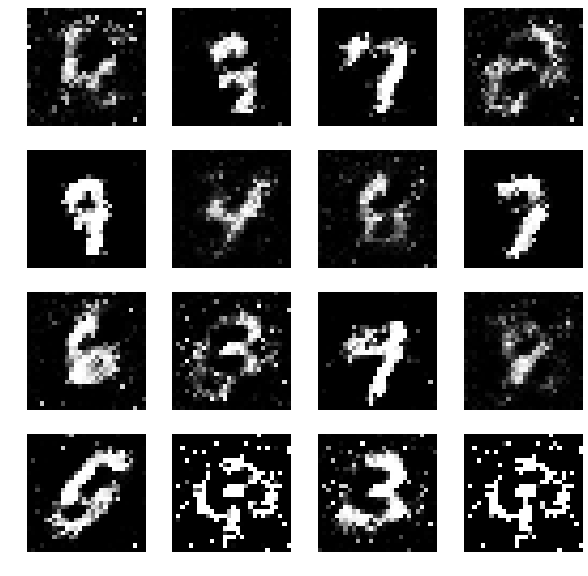

Epoch: 30000 Discriminator Loss: 0.356277, Generator Loss 1.422074


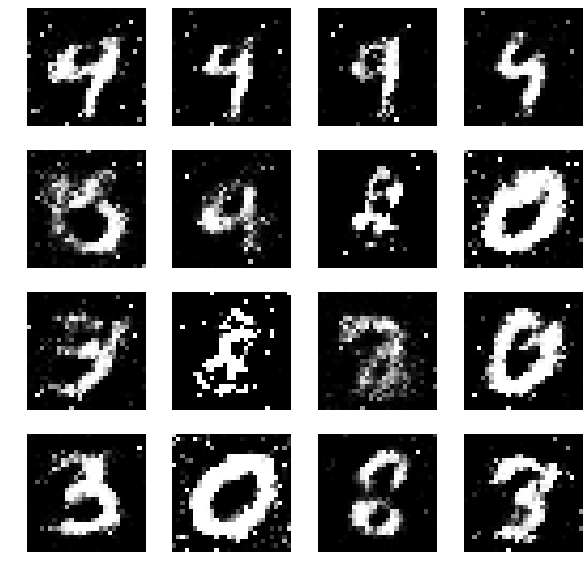

Epoch: 31000 Discriminator Loss: 0.474472, Generator Loss 1.979984


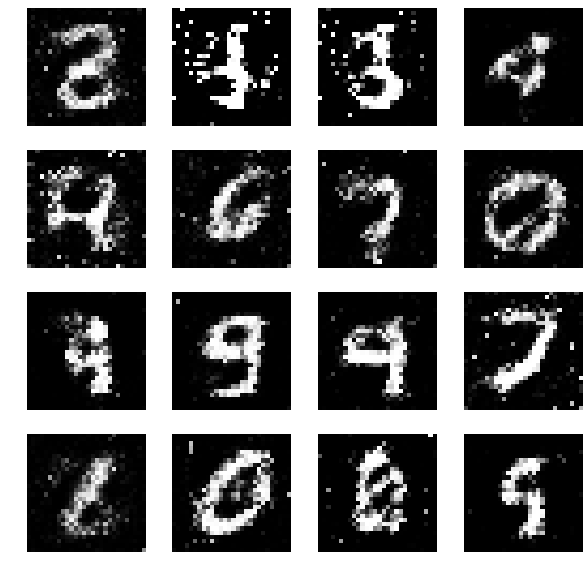

Epoch: 32000 Discriminator Loss: 0.502259, Generator Loss 2.289669


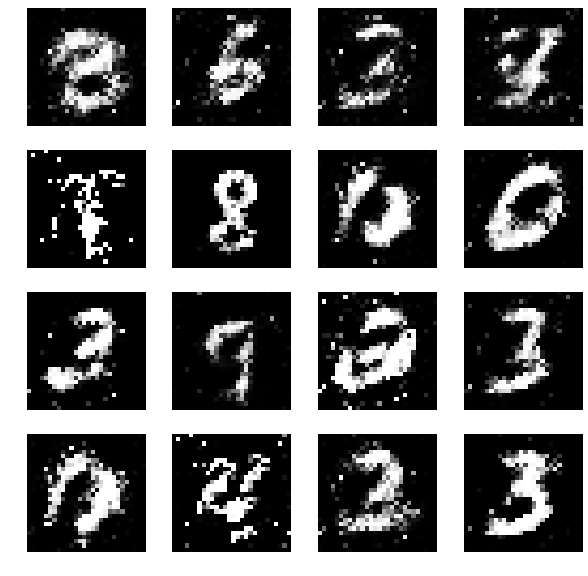

Epoch: 33000 Discriminator Loss: 0.452610, Generator Loss 1.678046


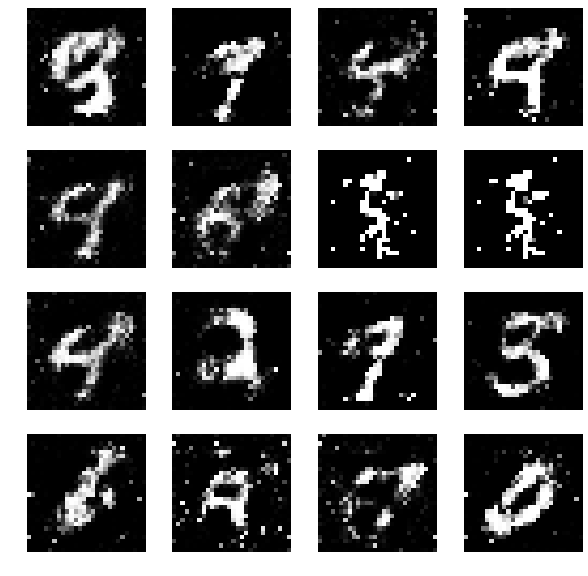

Epoch: 34000 Discriminator Loss: 0.428674, Generator Loss 1.874750


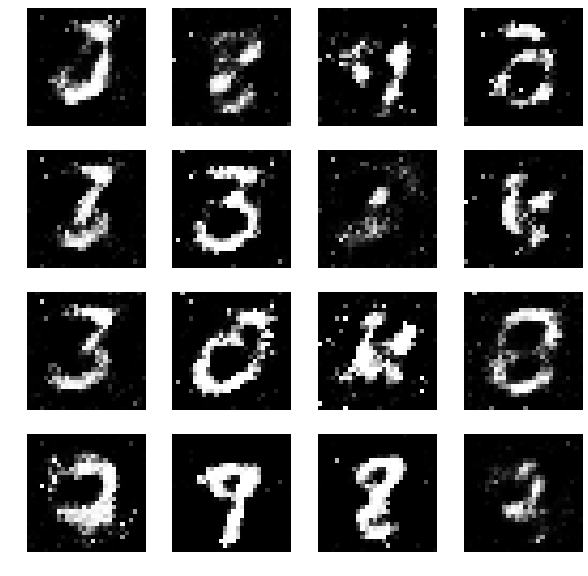

Epoch: 35000 Discriminator Loss: 0.619289, Generator Loss 0.993040


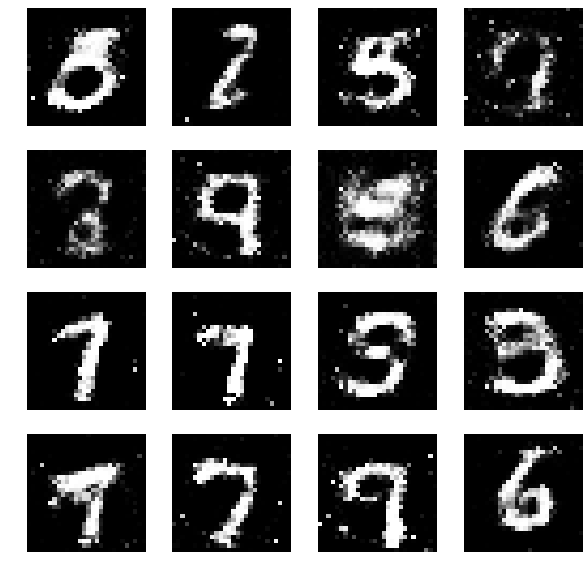

Epoch: 36000 Discriminator Loss: 0.422151, Generator Loss 1.663420


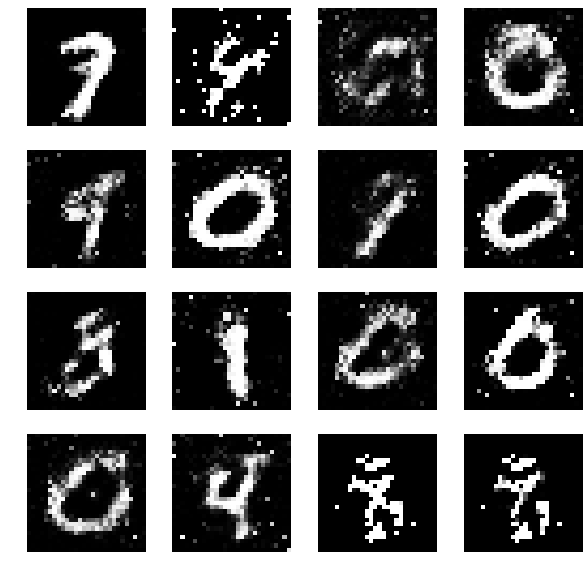

Epoch: 37000 Discriminator Loss: 0.327026, Generator Loss 2.183261


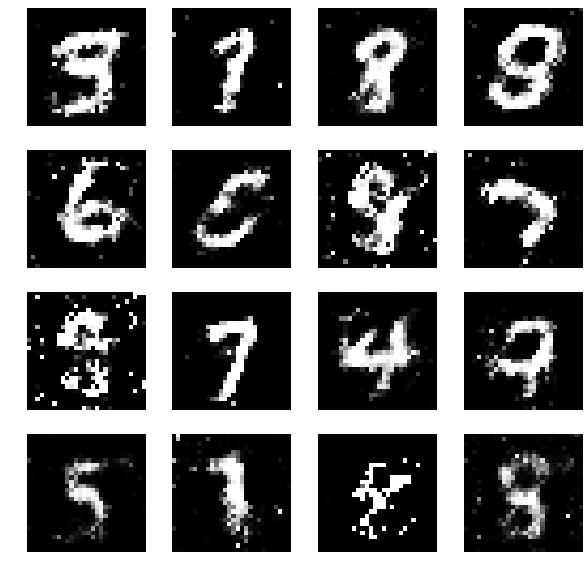

Epoch: 38000 Discriminator Loss: 0.551377, Generator Loss 1.654540


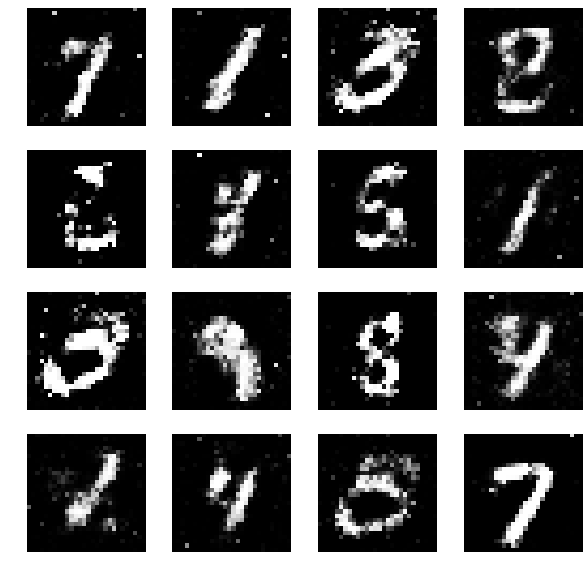

Epoch: 39000 Discriminator Loss: 0.364028, Generator Loss 1.734238


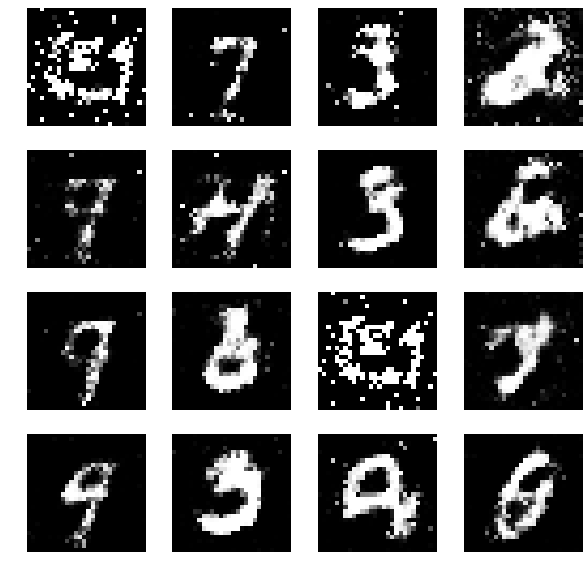

Epoch: 40000 Discriminator Loss: 0.522393, Generator Loss 1.730678


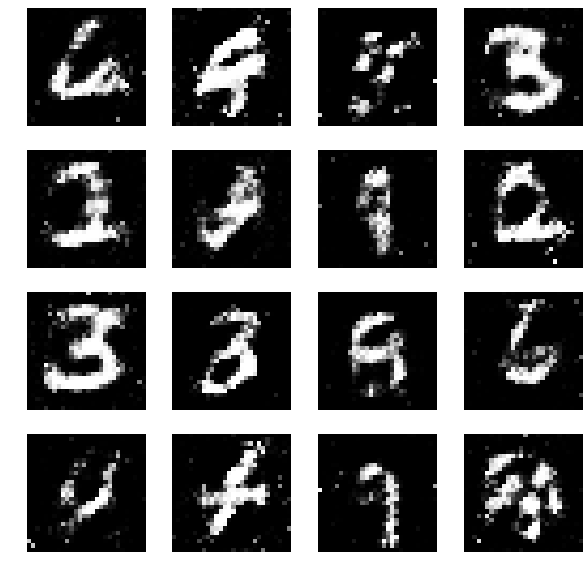

Epoch: 41000 Discriminator Loss: 0.430558, Generator Loss 1.428084


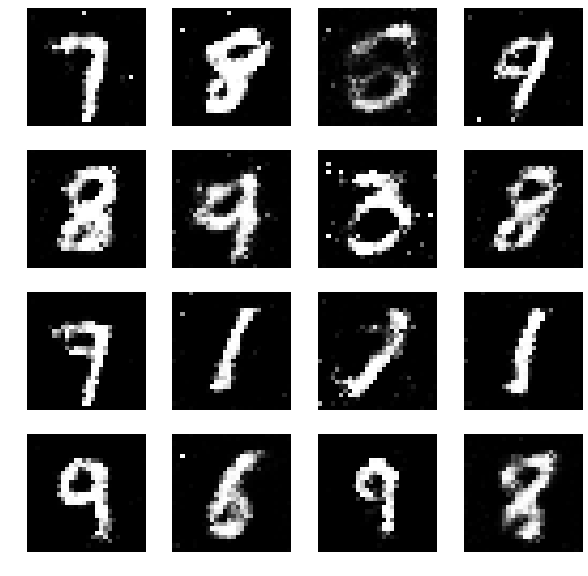

Epoch: 42000 Discriminator Loss: 0.503773, Generator Loss 1.227627


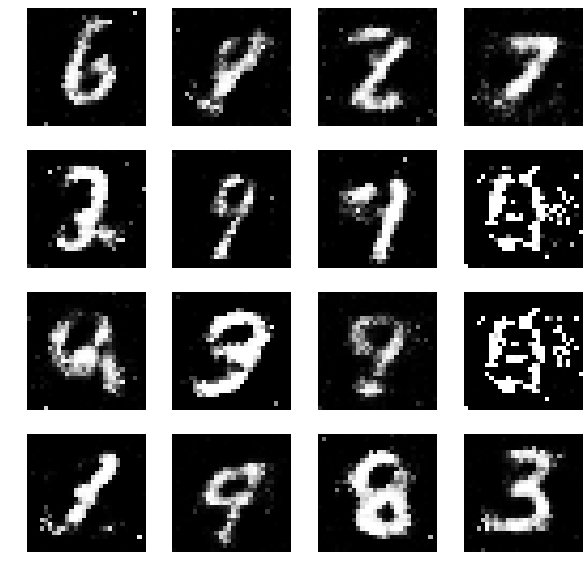

Epoch: 43000 Discriminator Loss: 0.430469, Generator Loss 1.454908


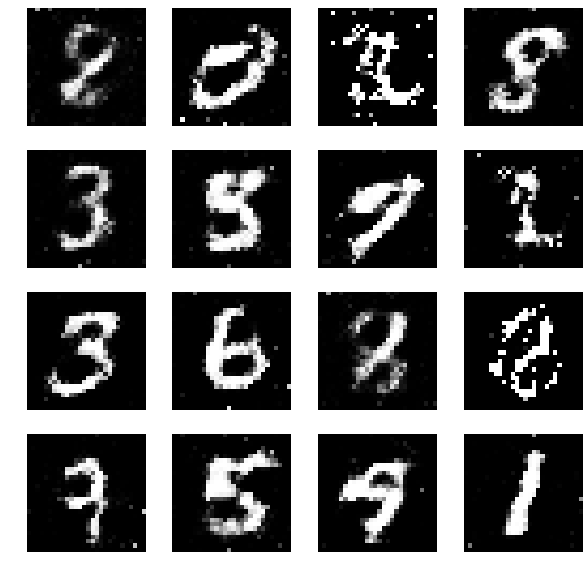

Epoch: 44000 Discriminator Loss: 0.476213, Generator Loss 1.126738


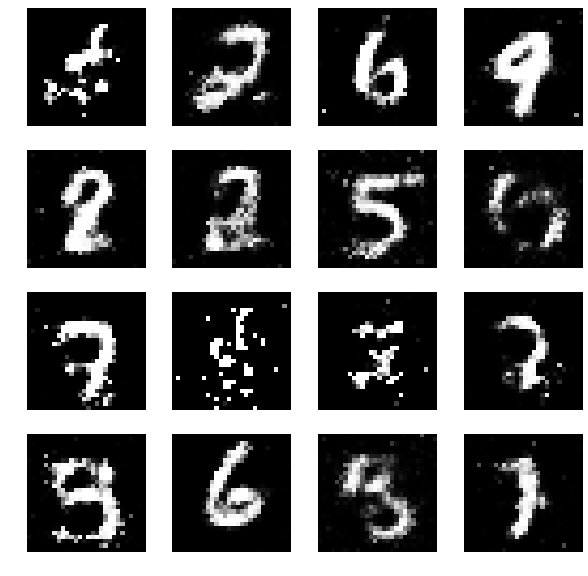

Epoch: 45000 Discriminator Loss: 0.462792, Generator Loss 1.197032


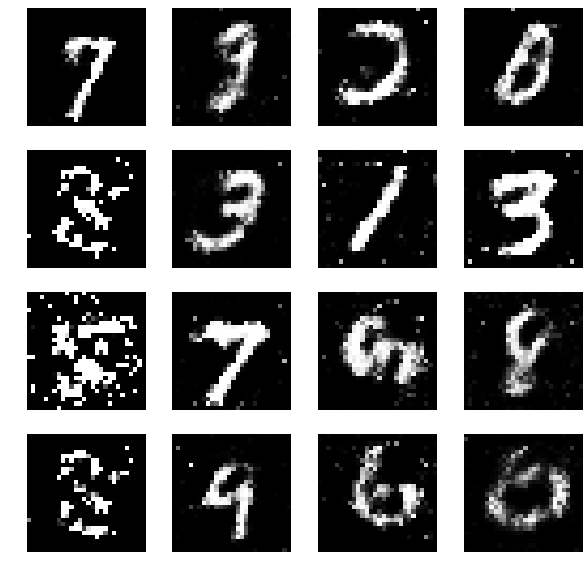

Epoch: 46000 Discriminator Loss: 0.433941, Generator Loss 1.717538


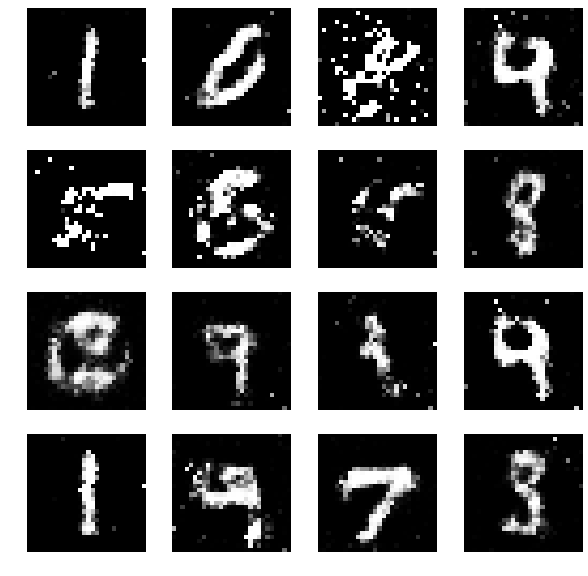

Epoch: 47000 Discriminator Loss: 0.336367, Generator Loss 1.617212


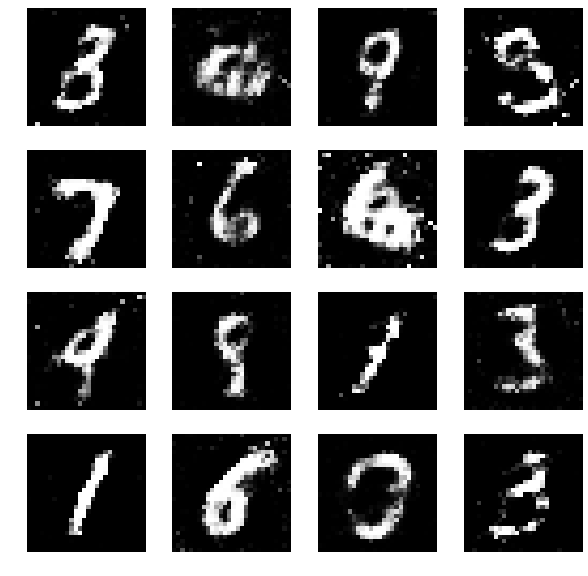

Epoch: 48000 Discriminator Loss: 0.303028, Generator Loss 2.076966


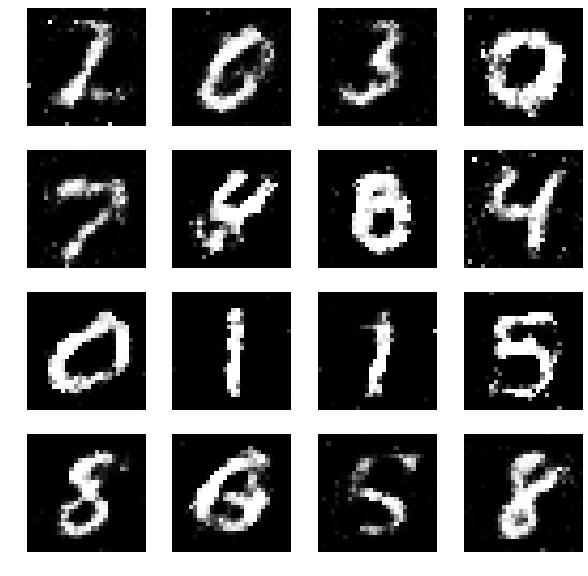

Epoch: 49000 Discriminator Loss: 0.663054, Generator Loss 1.356397


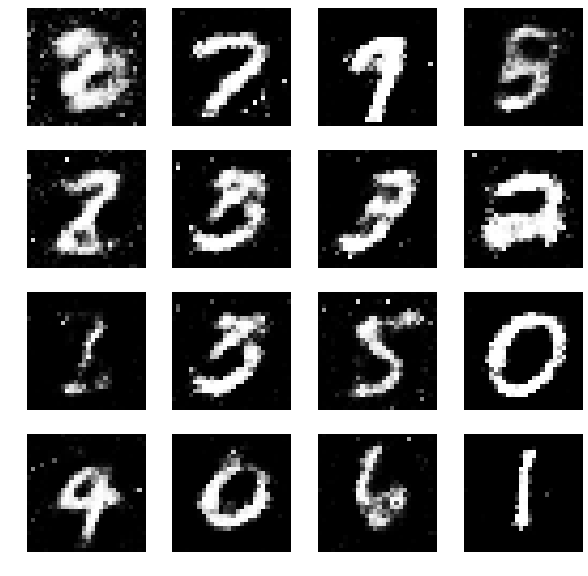

Epoch: 50000 Discriminator Loss: 0.536045, Generator Loss 1.547173


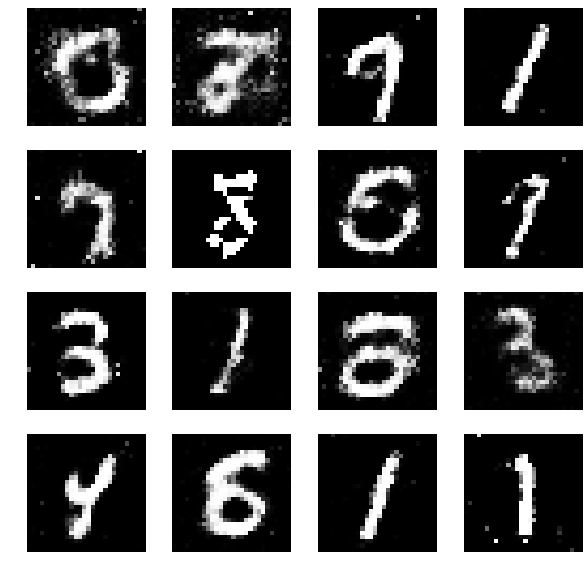

In [12]:
HEIGHT  = 28
WIDTH   = 28
CHANNEL = 1
LATENT_SPACE_SIZE = 100
EPOCHS = 50001
BATCH = 32
CHECKPOINT = 1000
MODEL_TYPE = -1

trainer = Trainer(height=HEIGHT,\
                 width=WIDTH,\
                 channels=CHANNEL,\
                 latent_size=LATENT_SPACE_SIZE,\
                 epochs =EPOCHS,\
                 batch=BATCH,\
                 checkpoint=CHECKPOINT,
                 model_type=MODEL_TYPE)
                 
trainer.train()
